# CURVETOPIA: A Journey into the World of Curves

### Welcome to Curvetopia, where we bring order and beauty to the world of 2D curves!
This project will guide you through identifying, regularizing, and beautifying various types of curves. Let’s dive in and explore.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import splprep, splev

In [4]:
# Define colors for plotting
COLORS = ['Black']

# Read CSV data
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = [npXYs[npXYs[:, 0] == j][:, 1:] for j in np.unique(npXYs[:, 0])]
        path_XYs.append(XYs)
    return path_XYs

In [5]:
# Plot functions
def plot(paths_XYs, colors=COLORS):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

In [6]:
# Simplify Polyline
def simplify_polyline(points, num_points=100):
    tck, u = splprep(points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), num_points)
    return np.column_stack(splev(u_new, tck))

In [7]:
# Determine if a polyline is a straight line
def is_straight_line(polyline, curvature_threshold=0.01):
    dx_dt = np.gradient(polyline[:, 0])
    dy_dt = np.gradient(polyline[:, 1])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    return np.mean(curvature) < curvature_threshold

In [8]:
# Fit ellipse to points
def fit_ellipse(x, y):
    def ellipse(x, y, x0, y0, a, b, theta):
        x_r = (x - x0) * np.cos(theta) + (y - y0) * np.sin(theta)
        y_r = -(x - x0) * np.sin(theta) + (y - y0) * np.cos(theta)
        return (x_r / a)**2 + (y_r / b)**2 - 1

    def fit_func(params):
        return ellipse(x, y, *params)

    x_center = np.mean(x)
    y_center = np.mean(y)
    a = np.max(x) - np.min(x)
    b = np.max(y) - np.min(y)
    if a < b:
        a, b = b, a
    p0 = [x_center, y_center, a / 2, b / 2, 0]
    bounds = [(None, None), (None, None), (0, None), (0, None), (-np.pi, np.pi)]
    result = optimize.least_squares(fit_func, p0, bounds=bounds, method='trf')
    
    return result.x

In [9]:
# Check if a polyline is a circle or ellipse
def is_circle_or_ellipse(polyline, threshold=0.1):
    x, y = polyline[:, 0], polyline[:, 1]
    try:
        params = fit_ellipse(x, y)
        residuals = np.abs(ellipse(x, y, *params))
        return np.mean(residuals) < threshold
    except:
        return False

In [10]:
# Convert detected shapes to Bézier curves
def bezier_line(start, end):
    return np.array([start, start * 2/3 + end * 1/3, start * 1/3 + end * 2/3, end])

def bezier_ellipse(params, num_points=100):
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, num_points)
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    
    return np.column_stack((x, y))

def convert_to_bezier(polyline):
    if is_straight_line(polyline):
        return bezier_line(polyline[0], polyline[-1])
    elif is_circle_or_ellipse(polyline):
        params = fit_ellipse(polyline[:, 0], polyline[:, 1])
        return bezier_ellipse(params)
    else:
        # For now, return the simplified polyline itself
        return polyline

def plot_bezier(bezier_curves):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for bezier_curve in bezier_curves:
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()


In [11]:
# Main Execution
def main(csv_path):
    paths_XYs = read_csv(csv_path)
    bezier_curves = [convert_to_bezier(polyline) for path in paths_XYs for polyline in path]
    plot_bezier(bezier_curves)

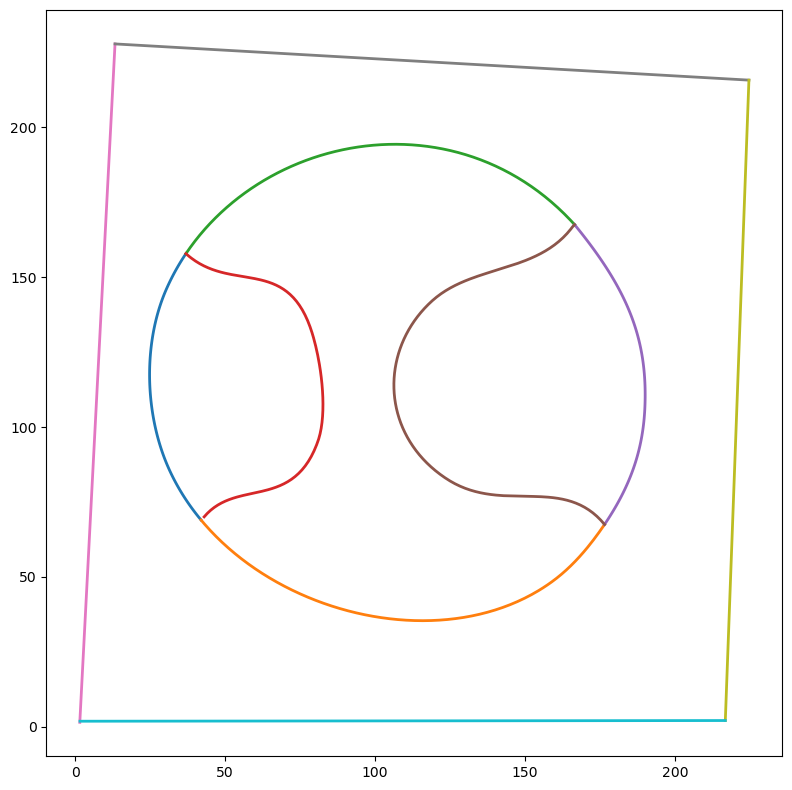

In [12]:
# Example usage
csv_path = r"C:\Users\Welcome\Documents\college\Projects\Curvetopia\problems\frag0.csv"
main(csv_path)
